# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [30]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy
import numpy as np
import sklearn
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


## Mutational catalogs and activities - WGS data

In [2]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [3]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(10)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Biliary-AdenoCA,SP117627,0.973,1110,528,0,0,1453,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Biliary-AdenoCA,SP117775,0.987,1803,1271,0,0,2199,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Biliary-AdenoCA,SP117332,0.987,441,461,0,0,840,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Biliary-AdenoCA,SP117712,0.948,122,0,0,0,6599,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Biliary-AdenoCA,SP117017,0.951,571,0,0,0,3804,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Biliary-AdenoCA,SP117031,0.976,1926,547,0,0,512,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Biliary-AdenoCA,SP117759,0.982,2403,1191,0,0,2684,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Biliary-AdenoCA,SP117621,0.989,2210,1605,0,0,2631,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,...,Stomach-AdenoCa::pfg316T,Stomach-AdenoCa::pfg317T,Stomach-AdenoCa::pfg344T,Stomach-AdenoCa::pfg373T,Stomach-AdenoCa::pfg375T,Stomach-AdenoCa::pfg378T,Stomach-AdenoCa::pfg398T,Stomach-AdenoCa::pfg413T,Stomach-AdenoCa::pfg416T,Stomach-AdenoCa::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,...,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,...,48,70,126,88,35,54,16,112,31,91


In [5]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(10)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ALL,SJBALL012_D,0.921,68,0,0,0,72,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ALL,SJBALL020013_D1,0.971,226,0,0,0,70,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ALL,SJBALL020422_D1,0.937,104,0,0,0,247,0,0,...,0,0,0,0,0,0,0,0,0,0
5,ALL,SJBALL020579_D1,0.921,68,0,0,0,227,0,0,...,0,0,0,0,0,0,0,0,0,0
6,ALL,SJBALL020589_D1,0.904,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,ALL,SJBALL020625_D1,0.922,43,0,0,0,139,0,0,...,0,0,0,0,0,0,0,0,0,0
8,ALL,SJBALL020704_D1,0.934,65,0,0,0,169,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ALL,SJBALL020877_D1,0.941,98,0,0,0,135,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(nonPCAWG_wgs_act['Cancer Types'].unique())

['ALL' 'AML' 'Biliary-AdenoCa' 'Blood-CMDI' 'Bone-cancer' 'Breast-cancer'
 'CNS-GBM' 'CNS-LGG' 'CNS-Medullo' 'CNS-glioma-NOS' 'ColoRect-AdenoCa'
 'Eso-AdenoCa' 'Ewings' 'Eye-Melanoma' 'Kidney-RCC' 'Liver-HCC'
 'Lung-AdenoCa' 'Lymph-BNHL' 'Lymph-CLL' 'Ovary-AdenoCa' 'Panc-AdenoCa'
 'Panc-Endocrine' 'Prost-AdenoCa' 'Sarcoma-bone' 'Sarcoma' 'Skin-Melanoma'
 'Stomach-AdenoCa']


## Mutational catalogs - WES data

In [7]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [10]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [11]:
### Aggregate mutation type and trinucleotides to one column
PCAWG_wgs_mut['tri_mut'] = PCAWG_wgs_mut[['Mutation type', 'Trinucleotide']].agg('_'.join, axis=1)
# 
nonPCAWG_wgs_mut['tri_mut'] = nonPCAWG_wgs_mut[['Mutation type', 'Trinucleotide']].agg('_'.join, axis=1)
# Concatenate both mutation count data sets
#total_wgs_mut = pd.concat([PCAWG_wgs_mut, nonPCAWG_wgs_mut], axis=1)
#total_wgs_mut.shape
#(96, 4651)
### Get cancer types
new_list = [re.sub(r'\:.*', '', i) for i in PCAWG_wgs_mut.columns]
# Transpose
PCAWG_wgs_mut_T = PCAWG_wgs_mut.T
# Rename columns
PCAWG_wgs_mut_T.columns = PCAWG_wgs_mut["tri_mut"]
PCAWG_wgs_mut_T["label"] = new_list[:]
PCAWG_wgs_mut_T = PCAWG_wgs_mut_T.iloc[2:,:] # we don't need to first 2 rows
print(len(PCAWG_wgs_mut_T['label'].unique()))

38


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 [Text(0, 0, 'Biliary-AdenoCA'),
  Text(1, 0, 'Bladder-TCC'),
  Text(2, 0, 'Bone-Benign'),
  Text(3, 0, 'Bone-Epith'),
  Text(4, 0, 'Bone-Osteosarc'),
  Text(5, 0, 'Breast-AdenoCA'),
  Text(6, 0, 'Breast-DCIS'),
  Text(7, 0, 'Breast-LobularCA'),
  Text(8, 0, 'CNS-GBM'),
  Text(9, 0, 'CNS-Medullo'),
  Text(10, 0, 'CNS-Oligo'),
  Text(11, 0, 'CNS-PiloAstro'),
  Text(12, 0, 'Cervix-AdenoCA'),
  Text(13, 0, 'Cervix-SCC'),
  Text(14, 0, 'ColoRect-AdenoCA'),
  Text(15, 0, 'Eso-AdenoCA'),
  Text(16, 0, 'Head-SCC'),
  Text(17, 0, 'Kidney-ChRCC'),
  Text(18, 0, 'Kidney-RCC'),
  Text(19, 0, 'Liver-HCC'),
  Text(20, 0, 'Lung-AdenoCA'),
  Text(21, 0, 'Lung-SCC'),
  Text(22, 0, 'Lymph-BNHL'),
  Text(23, 0, 'Lymph-CLL'),
  Text(24, 0, 'Myeloid-AML'),
  Text(25, 0, 'Myeloid-MDS'),
  Text(26, 0, 'Myeloid-MPN'),
  Text(27, 0, 'Ovar

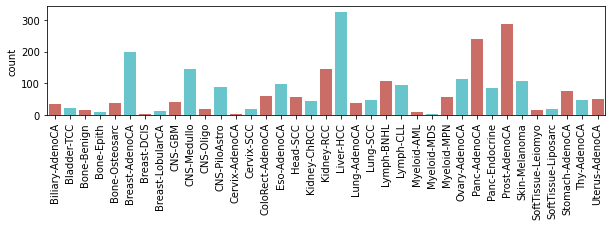

In [12]:
### Plot the amount of sampels in each cancer type.
plt.figure(figsize=(10, 2))
sns.countplot(x=new_list[2:-1], palette=sns.hls_palette(2))
plt.xticks(rotation=90)  

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [22]:
X = PCAWG_wgs_mut_T.values[:-1,:-1]
y = PCAWG_wgs_mut_T['label'].values[:-1]
features = list(PCAWG_wgs_mut_T.columns)[:-1]


lc = LabelEncoder() 
lc = lc.fit(y) 
lc_y = lc.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, lc_y, test_size=0.2, random_state=5)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

[14 18 35 ... 21 26 30]
['ColoRect-AdenoCA' 'Kidney-RCC' 'Thy-AdenoCA' ... 'Lung-SCC'
 'Myeloid-MPN' 'Prost-AdenoCA']


model = XGBClassifier(verbosity = 0, use_label_encoder=False, objective = 'multi:softmax', num_class = 37, n_estimators = 500)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
predictions = [round(pred) for pred in y_pred] 
accuracy = accuracy_score(y_test, predictions)
print(accuracy) 

learning_rate = [0.1,0.3,0.5,0.8] #default = 0.3
gamma = [0,0.5,1,5] #default = 0
max_depth = [4,6,10,20] #default = 6
max_delta_step = [0,2,4,6] #default = 0

column_list = ['learning_rate','gamma','max_depth','max_delta_step','accuracy']
results = pd.DataFrame(columns = column_list)
i = 1
for a in learning_rate:
    for b in gamma:
        for c in max_depth:
            for d in max_delta_step:
                print(f"training model {i}\n")
                i += 1
                model = XGBClassifier(verbosity = 0,learning_rate=a, gamma=b, max_depth=c, max_delta_step=d, use_label_encoder=False)
                model.fit(X_train,y_train)
                y_pred = model.predict(X_test)
                predictions = [round(pred) for pred in y_pred] 
                accuracy = accuracy_score(y_test, predictions) 
                results = results.append({'learning_rate':a,'gamma':b,'max_depth':c,'max_delta_step':d,'accuracy':accuracy},ignore_index=True)

results.to_csv("results.csv")

In [ ]:
learning_rate = [0.01,0.1,0.3] #default = 0.3
gamma = [0,1,5] #default = 0
max_depth = [3,6,10] #default = 6
colsample_bytree = [0.3,0.55,0.8]


column_list = ['learning_rate','gamma','max_depth','colsample_bytree','accuracy']
results2 = pd.DataFrame(columns = column_list)
i = 1
for a in learning_rate:
    for b in gamma:
        for c in max_depth:
            for d in colsample_bytree:
                print(f"training model {i}")
                i += 1
                model = XGBClassifier(objective = 'multi:softmax', num_class = 37,n_estimators = 1000, verbosity = 0,learning_rate=a, gamma=b, max_depth=c, colsample_bytree=d, use_label_encoder=False)
                model.fit(X_train,y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred) 
                print(accuracy,"\n")
                results2 = results2.append({'learning_rate':a,'gamma':b,'max_depth':c,'colsample_bytree':d,'accuracy':accuracy},ignore_index=True)

results2.to_csv("results2.csv")

In [27]:
model = XGBClassifier(objective = 'multi:softmax', num_class = 37,n_estimators = 1000, verbosity = 0,learning_rate=0.1, gamma=0, max_depth=6, colsample_bytree=0.55, use_label_encoder=False)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
predictions = lc.inverse_transform(y_pred)
actuals = lc.inverse_transform(y_test)

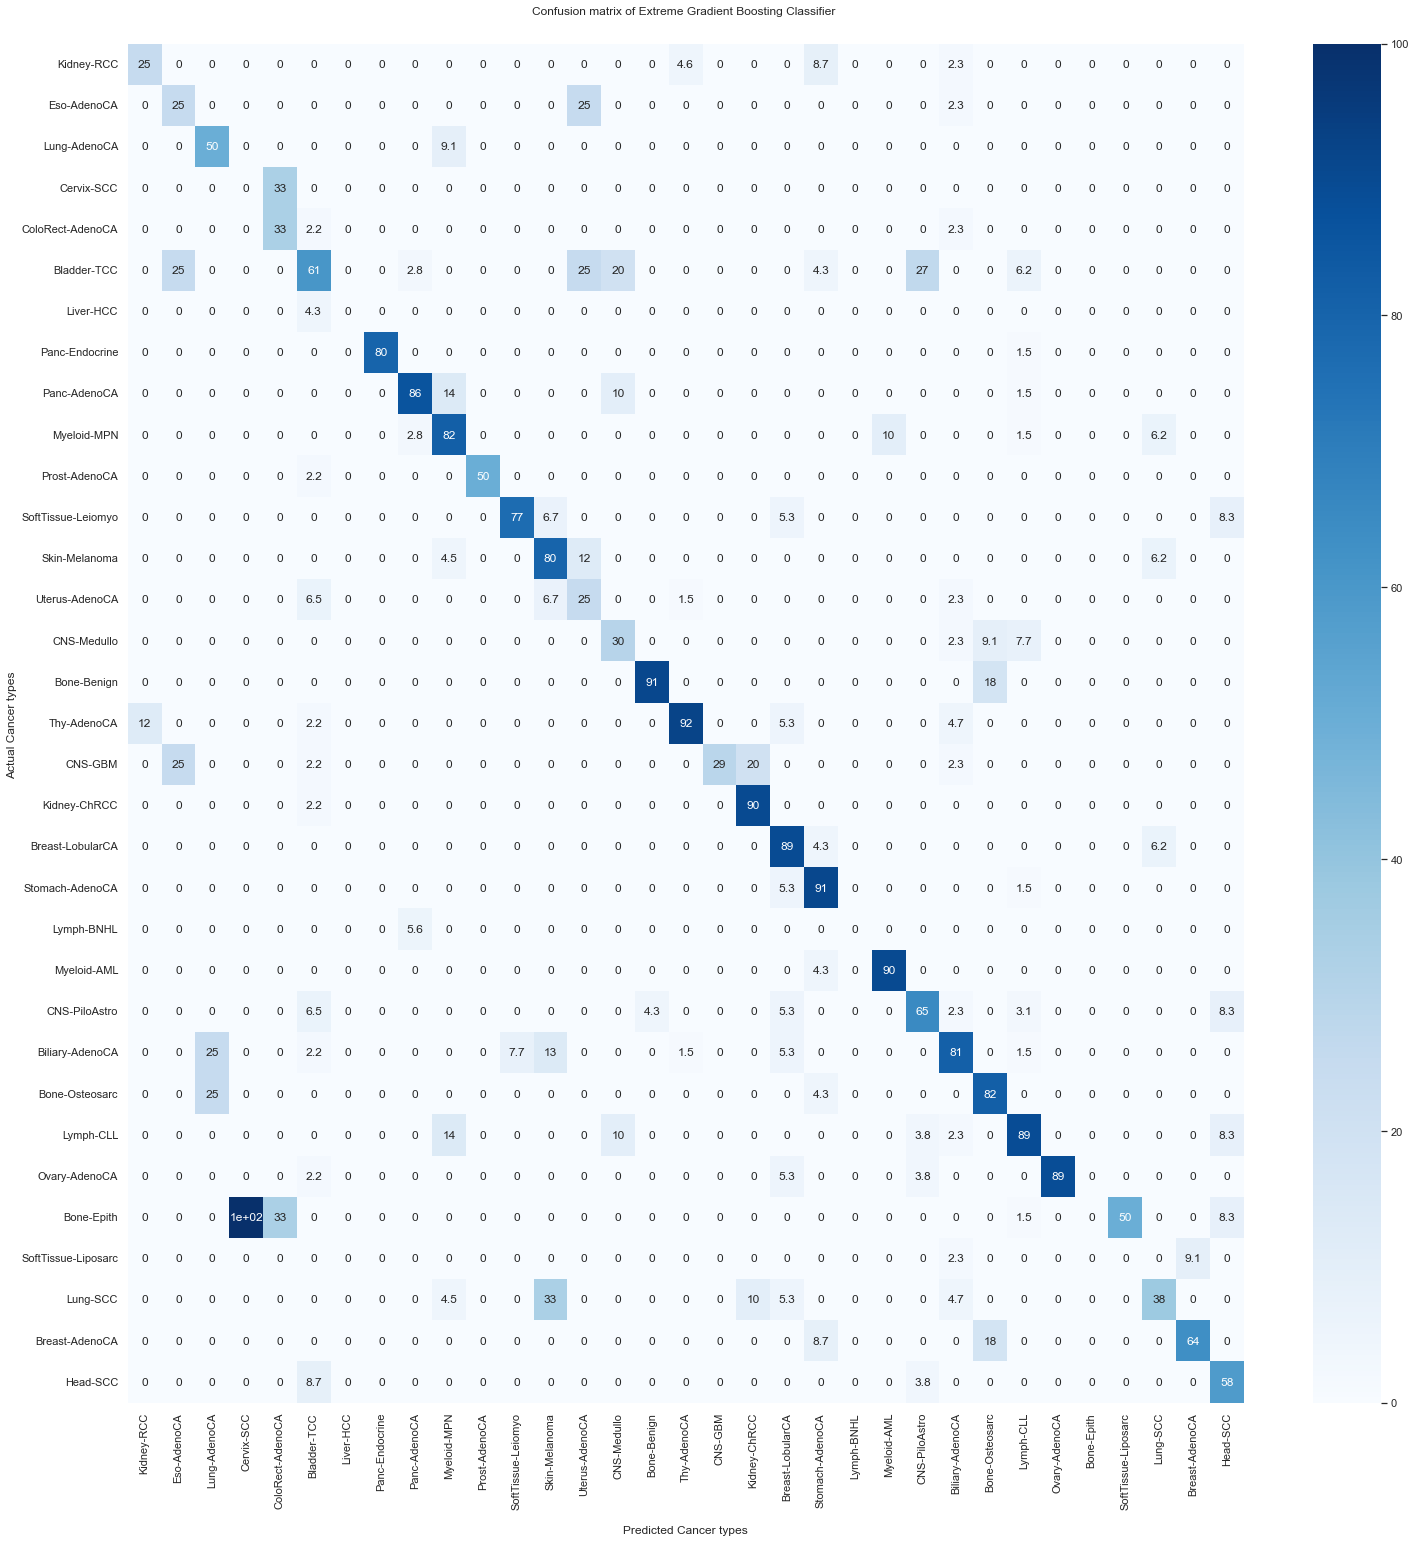

In [34]:
cf_matrix = confusion_matrix(actuals, predictions)
tp_and_fn = cf_matrix.sum(1)

plt.figure(figsize=(25, 25)) # Choose figure size
sns.set(font_scale = 1) # set font size

#ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues') # do heat map, cmap = color scheme
ax = sns.heatmap(100*(cf_matrix/tp_and_fn), annot=True, cmap='Blues') # plot as precentages

ax.set_title('Confusion matrix of Extreme Gradient Boosting Classifier \n\n') # set plot title
ax.set_xlabel('\nPredicted Cancer types') # set x label
ax.set_ylabel('Actual Cancer types ') # set y label

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(set(list(actuals))) # set x ticks as cancer types
ax.yaxis.set_ticklabels(set(list(actuals))) # set y ticks as cancer types
plt.xticks(rotation=90) # rotate ticks
plt.yticks(rotation=0)   # rotate ticsk
plt.show()

In [3]:
# load all the functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC # support vector machine
from sklearn.ensemble import RandomForestClassifier
